# chapter8. 비지도학습

## 8.1 K-평균 알고리즘
- 클러스터링 : 입력 데이터로부터 특성을 뽑아 유사 성질들을 군집화
- k-means : 각 클러스터(그룹)의 평균을 기준으로 점들을 배치시키는 알고리즘
- 특정 거리 함수를 통해 각 중심(centroid)과 입력값의 거리를 측정하고 그 중 가장 가까운 그룹으로 할당을 함
- 모든 점이 할당되면 각 그룹의 평균을 구해 중심을 업데이트하고 위 과정을 반복

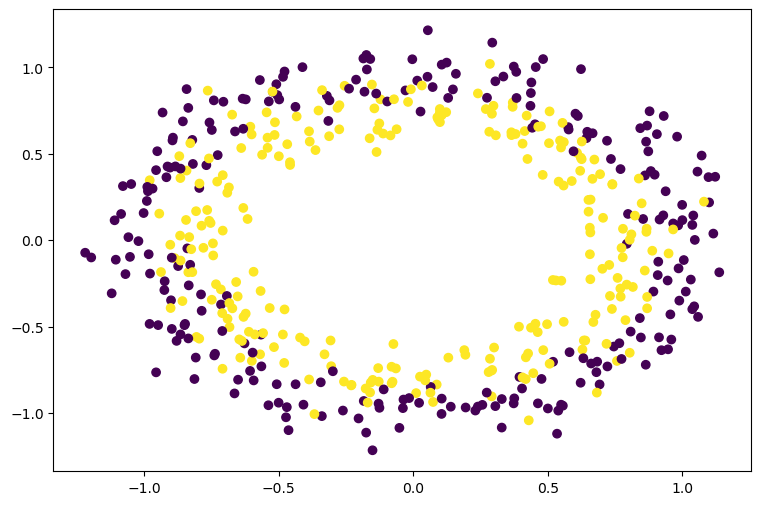

In [20]:
# 데이터 만들기
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

x, y = make_circles(n_samples=500, noise=0.1)
plt.figure(figsize=(9,6))
plt.scatter(x[:,0],x[:,1], c=y)
plt.show()

In [21]:
# 텐서 데이터로 변환하기
x = torch.FloatTensor(x)

In [22]:
# K-means
def l2distance(a,b):
    return torch.argmin(torch.sum((a-b)**2,dim=1),dim=0)

In [23]:
def kmeans(x, num_clusters = 2, max_iteration = 5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    x = x.to(device)
    centroids = torch.rand(num_clusters, x.size(1)).to(device)
    for update in range(x.size(0)):
        y_assign = []
        for m in range(x.size(0)):
            h = x[m].expand(num_clusters,-1) # 입력값을 클러스터 개수만큼 복사하여 할당
            assign = l2distance(h,centroids)
            y_assign.append(assign.item())

        y_assign = np.array(y_assign)
        if update != max_iteration-1:
            for i in range(num_clusters):
                idx = np.where(y_assign == i)[0]
                centroids[i] = torch.mean(x[idx], dim=0)
    return y_assign, centroids


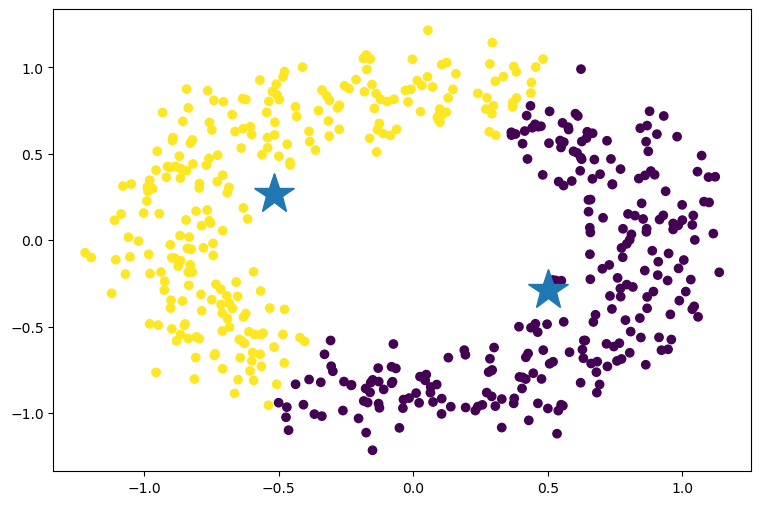

In [24]:
# 알고리즘 실행 및 그래프 그리기
y_pred, centroids = kmeans(x,2)
plt.figure(figsize=(9,6))
plt.scatter(x[:,0],x[:,1], c=y_pred)
plt.plot(centroids[:,0],centroids[:,1],'*',markersize = 30)
plt.show()


## 8.3 오토인코더
- 오토인코더는 정답 없이 모델을 학습시키는 비지도 학습 모델
- 인코더 : 입력데이터를 압축, 디코더 : 압축을 품
- 인코더를 통해 차원 축소가 된 latent variable (잠재변수)를 가지고 별도로 계산을 할수도 있고 디코더를 통해 입력값과 유사한 값을 생성할 수 도 있다.

### 8.3.1 스택 오토인코더

In [25]:
# 라이브러리
import torch
import torchvision
from torchvision import transforms
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#dataset = torchvision.datasets.MNIST('./data/', download=True, train=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(dataset,batch_size = 50, shuffle= True)

In [26]:
# 모델 구축하기
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784,128),
            nn.ReLU(),
            nn.Linear(128,32),
            nn.ReLU(),
            nn.Linear(32,10),
            nn.ReLU())
        
        self.decoder = nn.Sequential(
            nn.Linear(10,32),
            nn.ReLU(),
            nn.Linear(32,128),
            nn.ReLU(),
            nn.Linear(128,28*28),
            nn.Sigmoid())    
        
    def forward(self,x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [27]:
# 모델, 손실함수, 최적화

model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=1e-4)

In [ ]:
# 학습하기
for epoch in range(51):
    running_loss = 0.0
    for data in trainloader:
        inputs = data[0].to(device)
        optimizer.zero_grad()
        outputs = model(inputs.view(-1,28*28))
        outputs = outputs.view(-1,1,28,28)
        loss = criterion(inputs,outputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    cost = running_loss/len(trainloader)
    print('[%d] loss : %.3f' % (epoch+1,cost))

### 8.3.2 디노이징 오토인코더